In [1]:
import pandas as pd
import numpy as np
import os
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from torch import nn, optim
from torch.autograd import Variable
import torch
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

In [2]:
os.chdir(r'/home/grejell/Projects/nba-shots-streamlit-app') 

X_train = pd.read_pickle('./data/X_train.pkl')
Y_train = pd.read_pickle('./data/Y_train.pkl')
x_test = pd.read_pickle('./data/x_test.pkl')
y_test = pd.read_pickle('./data/y_test.pkl')

data = pd.concat([X_train, Y_train], axis=1)
data = data.rename(columns={'labels':'target'})

data.target.value_counts()

0    52642
1    43409
Name: target, dtype: int64

In [3]:
X = data.drop(['target'], axis=1)
y = data.target

In [7]:
def convert_to_tensor(X, Y, x_test, y_test):
    # making sure the training will use gpu
    #     torch.cuda.set_device(0)
    #     torch.backends.cudnn.benchmark=True
    # convert all dataset to cuda tensor to be able to use the GPU
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    dtype = torch.FloatTensor
    X = np.array(X)
    x_test = np.array(x_test)
    Y = np.array(Y)
    y_test = np.array(y_test)
    X_train = torch.tensor(X, device=device).type(dtype)
    x_test = torch.tensor(x_test, device=device).type(dtype)


    Y_train = torch.tensor(Y, device=device).type(dtype)
    y_test = torch.tensor(y_test, device=device).type(dtype)

    Y_train = torch.unsqueeze(Y_train, 1)
    y_test = torch.unsqueeze(y_test, 1)
    return X_train, x_test, Y_train, y_test

from torch.utils.data.dataloader import DataLoader
X_train, x_test, Y_train, y_test = convert_to_tensor(X_train, Y_train, x_test, y_test)

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(start, 200)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.3)
                
        self.fc2 = nn.Linear(200, 200)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.3)
        
        self.fc6 = nn.Linear(200, 100)
        self.prelu = nn.PReLU(1)
        
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        dout = self.dout(h2)
        
        a6 = self.fc6(dout)
        h6 = self.prelu(a6)
        
        a7 = self.out(h6)
        
        y = self.out_act(a7)
        return y

In [9]:
start = len(X.columns)

In [10]:
model = Classifier()
criterion = nn.BCELoss() ## loss function for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001) ## adam optimizer

In [14]:
# torch.backends.cudnn.benchmark=True
n_epochs = 1000
e_losses = []
former_loss = 9999999999999999999999999999

for epoch in range(n_epochs):
    
    # forward pass
    outputs = model.forward(X_train)

    # calculate loss (MSE)
    loss = criterion(outputs, Y_train)
    e_losses.append(loss.data)

    # compute gradients
    loss.backward()
    
    # perform one step in the oposite direction to the gradient (update weights)
    optimizer.step()
    
    # clear gradient values after weights are updated
    optimizer.zero_grad()
    
    if loss <= min(e_losses):
        torch.save(model.state_dict(), '.\models\model_pytorch.pt')
        print('model saved at epoch {}, with loss {}'.format(epoch, loss.item()))
        last_epoch = epoch
        last_loss = loss.item()
    
    if epoch % 100 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
#         current_loss = loss.item()
#         if former_loss - current_loss < 0:
#             print('early stopping at epoch {}, model saved at epoch {}, with loss {}'.format(epoch, last_epoch, last_loss))
#             break
#         else:
#             former_loss = current_loss



model saved at epoch 0, with loss 0.5908629894256592
epoch 0, loss 0.5908629894256592
model saved at epoch 1, with loss 0.5891526341438293
model saved at epoch 2, with loss 0.5889909863471985
model saved at epoch 3, with loss 0.5887868404388428
model saved at epoch 7, with loss 0.587428092956543
model saved at epoch 8, with loss 0.5868326425552368
model saved at epoch 11, with loss 0.5858917236328125
model saved at epoch 12, with loss 0.5846949815750122
model saved at epoch 16, with loss 0.5841392278671265
model saved at epoch 22, with loss 0.5840159058570862
model saved at epoch 23, with loss 0.5812128782272339
model saved at epoch 28, with loss 0.5780591368675232
model saved at epoch 36, with loss 0.5772941708564758
model saved at epoch 40, with loss 0.5757769346237183
model saved at epoch 44, with loss 0.5734343528747559
model saved at epoch 49, with loss 0.5724413990974426
model saved at epoch 52, with loss 0.5719475150108337
model saved at epoch 53, with loss 0.5697471499443054
mo

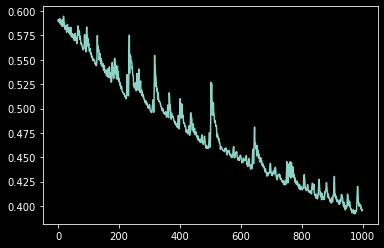

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use(['dark_background'])        
plt.plot(e_losses)

In [ ]:
model = Classifier()
#model.load_state_dict(torch.load(r'.\models\model_pytorch.pt'))
model.eval()

In [ ]:

def predict_new_data(x_test, y_test, model):
    # switch to evaluation mode
    model = model.eval()
    dtype = torch.FloatTensor

    x_test = torch.tensor(x_test).type(dtype)
    with torch.no_grad():
        y_pred_prob = model.forward(x_test).cpu().numpy()

    y_pred = y_pred_prob >= 0.5
    y_pred = y_pred.astype(int)
    y_test = y_test.cpu().numpy()
    accuracy = metrics.accuracy_score(y_pred, y_test).astype(str)
    print('\n\naccuracy is ' + accuracy)

    precision = metrics.precision_score(y_test, y_pred).astype(str)
    print('precision is ' + precision)
    recall = metrics.recall_score(y_test, y_pred).astype(str)
    print('recall is ' + recall)
    auc = metrics.roc_auc_score(np.asarray(y_test), y_pred).astype(str)
    print('auc is ' + auc)

    f1 = 2*((precision.astype(np.float64)*recall.astype(np.float64))/(precision.astype(np.float64)+recall.astype(np.float64)))
    print('f1-score is ' + f1.astype(str))
    
    return y_pred, y_pred_prob

y_pred_train, y_pred_train_prob = predict_new_data(X_train, Y_train, model)
y_pred_test, y_pred_test_prob= predict_new_data(x_test, y_test, model)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 10))
%matplotlib inline

Y_train_pd = Y_train.cpu().numpy()
preds = pd.DataFrame({'target':pd.Series(map(lambda x: x[0], Y_train_pd)), 'predicted':pd.Series(map(lambda x: x[0], y_pred_train_prob))})

plt.style.use(['dark_background'])
plot = sns.distplot(preds['predicted'][preds['target']==0], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color='red')
plot = sns.distplot(preds['predicted'][preds['target']==1], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color='blue')
plt.title('predicted for Train')
plt.show(plot)
print('mean for red '+str(preds['predicted'][preds['target']==0].mean()))
print('mean for blue '+str(preds['predicted'][preds['target']==1].mean()))